# Customer transaction prediction

Problem Statement:

* In this challenge, we need to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

# Load Packages

In [1]:
#Loading all Libraries:-

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp, get_dataset, info_plots
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,roc_curve,auc


random_state=42
np.random.seed(random_state)
import warnings
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from scipy import stats
from scipy.stats import norm
from copy import deepcopy
warnings.filterwarnings('ignore')


# Data Exploration

In [2]:
df_train=pd.read_csv("train.csv")

In [3]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
#Shape of the dataset
df_train.shape

(200000, 202)

In [5]:
#Summary of the dataset
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [6]:
df_train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [7]:
df_train.sum()

ID_code    train_0train_1train_2train_3train_4train_5trai...
target                                                 20098
var_0                                            2.13598e+06
var_1                                                -325524
var_2                                            2.14304e+06
                                 ...                        
var_195                                             -28417.7
var_196                                               460667
var_197                                          1.78163e+06
var_198                                          3.17414e+06
var_199                                              -665307
Length: 202, dtype: object

In [8]:
df_train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [9]:
df_train.isna().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

#### It is found that no missig and NAN values present in the data set

# Exploratory data analysis

Text(0.5, 1.0, 'Distribution in Target Variable ')

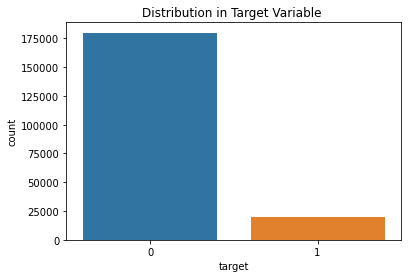

In [10]:
#checking the data distribution in target column
sns.countplot(df_train['target'])
plt.title("Distribution in Target Variable ")

In [11]:
#Target Class Count
target_class=df_train['target'].value_counts()
print('Count of the target class :\n',target_class)

#Percentage of target class count
per_target_class=df_train['target'].value_counts()/len(df_train)*100
print('Percentage of target class count :\n',per_target_class)

Count of the target class :
 0    179902
1     20098
Name: target, dtype: int64
Percentage of target class count :
 0    89.951
1    10.049
Name: target, dtype: float64


##### From the above graph it is found that the given data is imbalenced data as it has 89.95% of value:0 and 10.05% value: 1.



In [12]:
%%time
#Finding the missing values in train & test dataset:-
train_missing=df_train.isnull().sum().sum()

print('Missing values in train data:',train_missing)


Missing values in train data: 0
Wall time: 79.6 ms


In [39]:
# It is found that no missing values in the data set

In [13]:
#creating columns list
cnames = df_train.drop(['target','ID_code'],axis=1).columns
cnames

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

<AxesSubplot:>

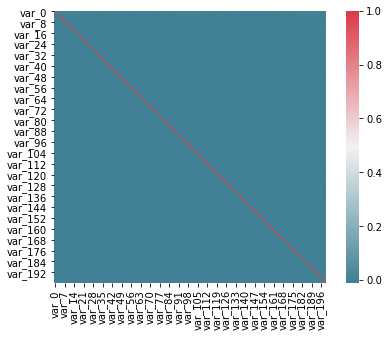

In [14]:
df_corr= df_train.loc[:,cnames]
f,ax= plt.subplots(figsize=(7,5))
corr= df_corr.corr()
sns.heatmap(corr,mask= np.zeros_like(corr,dtype= np.bool),cmap= sns.diverging_palette(220,10,as_cmap= True),square= True,ax=ax)

In [15]:
#form the above plot the variables are not corelated

In [16]:
%%time 

#Distribution of train attributes-

def plot_train_attribute_distribution(t0,t1,label1,label2,train_attributes):
    i=0
    sns.set_style('darkgrid')
    
    fig=plt.figure()
    ax=plt.subplots(10,10,figsize=(22,18))
    
    for attribute in train_attributes :
        i+=1
        plt.subplot(10,10,i)
        sns.distplot(t0[attribute],hist=False,label=label1)
        sns.distplot(t1[attribute],hist=False,label=label2)
        plt.legend()
        plt.xlabel('Attribute',)
        sns.set_style("ticks",{"xtick.major.size": 8, "ytick.major.size": 8})
    plt.show()

Wall time: 0 ns


<Figure size 432x288 with 0 Axes>

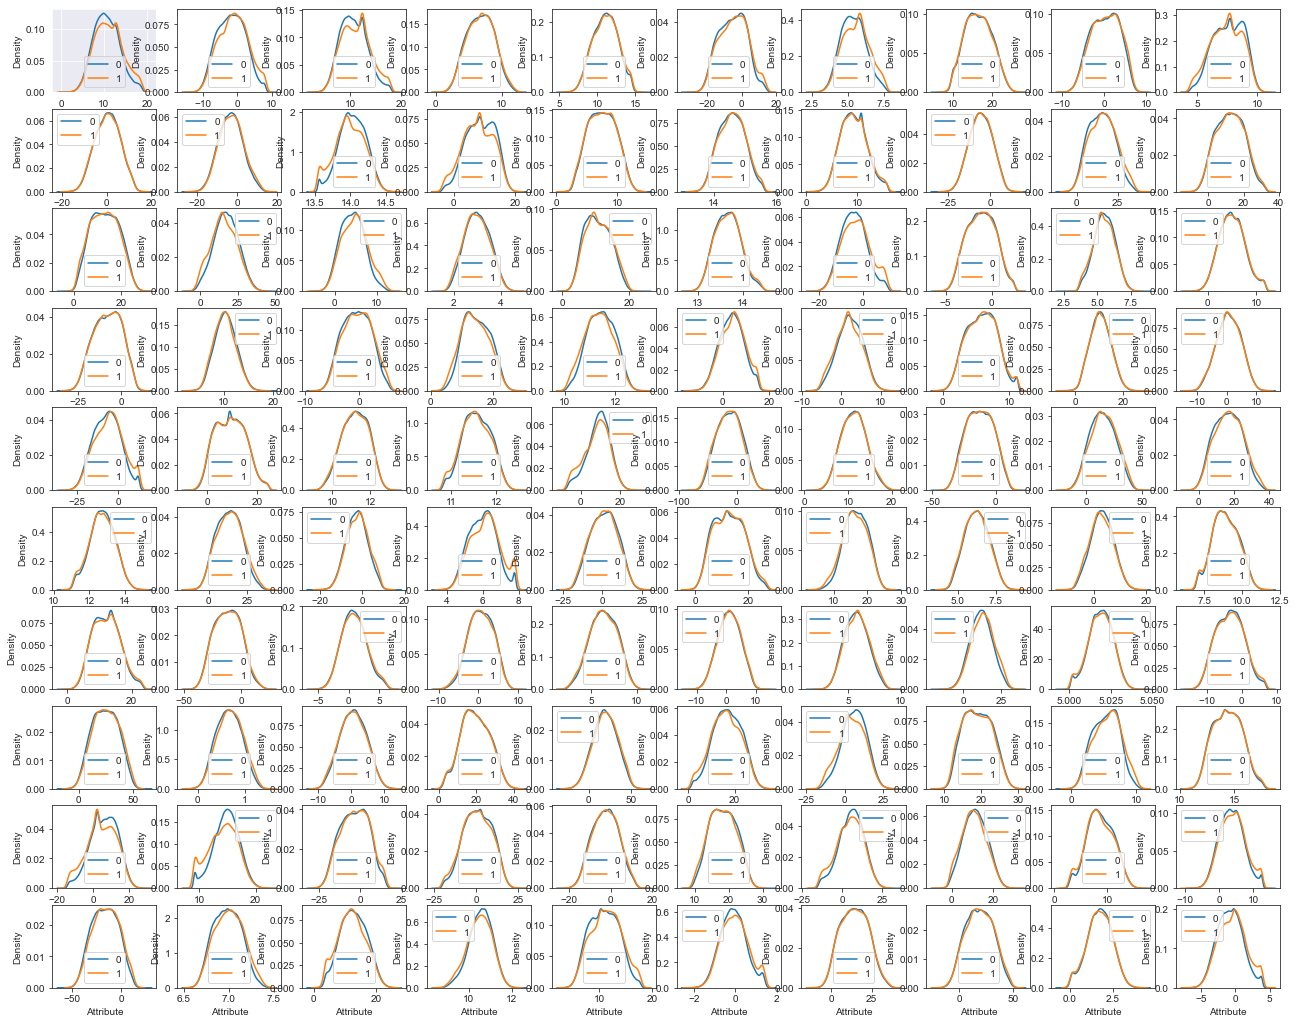

Wall time: 1min 16s


In [17]:
%%time
#Corresponding to negative class-
t0=df_train[df_train.target.values==0]

#Corresponding to possitive class-
t1=df_train[df_train.target.values==1]

#train attributes from 2 to 102 -
train_attributes=df_train.columns.values[2:102]

#Plot distribution of train attributes-
plot_train_attribute_distribution(t0,t1,'0','1',train_attributes)

<Figure size 432x288 with 0 Axes>

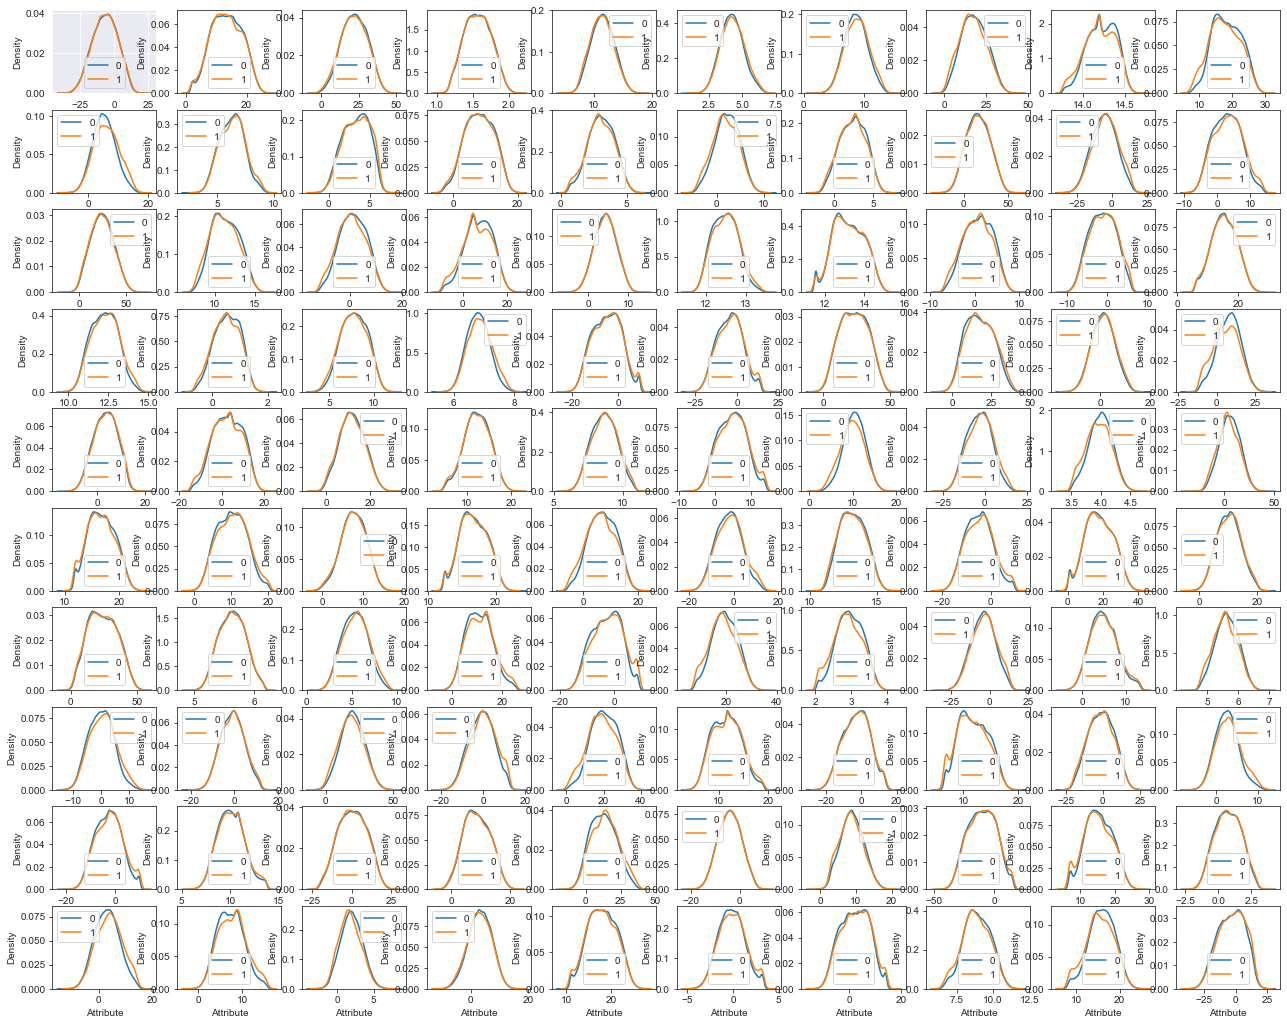

In [18]:
#train attributes from 102 to 202 -
train_attributes=df_train.columns.values[102:202]

#Plot distribution of train attributes-
plot_train_attribute_distribution(t0,t1,'0','1',train_attributes)

##### From the above graphs it is found that it has im balanced data and more similar distribution (repeated values for example var_10, and var_14) so we need to normalize the data


In [20]:
%%time
#Correlation in train attiributes-
train_attributes=df_train.columns.values[2:202]
train_correlation=df_train[train_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
train_correlation=train_correlation[train_correlation['level_0']!=train_correlation['level_1']]
print(train_correlation.head(10))
print(train_correlation.tail(10))

   level_0  level_1             0
0   var_75  var_191  2.703975e-08
1  var_191   var_75  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07
5  var_109  var_126  1.313947e-07
6  var_144   var_27  1.772502e-07
7   var_27  var_144  1.772502e-07
8  var_177  var_100  3.116544e-07
9  var_100  var_177  3.116544e-07
       level_0  level_1         0
39790  var_183  var_189  0.009359
39791  var_189  var_183  0.009359
39792  var_174   var_81  0.009490
39793   var_81  var_174  0.009490
39794   var_81  var_165  0.009714
39795  var_165   var_81  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798   var_26  var_139  0.009844
39799  var_139   var_26  0.009844
Wall time: 15.2 s


In [21]:
#Spliting the data via Sratified KFold Cross Validator:-

#Training Data:
X=df_train.drop(['ID_code','target'],axis=1)
Y=df_train['target']

#Stratified KFold Cross Validator:-
skf=StratifiedKFold(n_splits=5, random_state=562, shuffle=True)
for train_index, valid_index in skf.split(X,Y): 
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] 
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    
print('Shape of X_train :',X_train.shape)
print('Shape of X_valid :',X_valid.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_valid.shape)

Shape of X_train : (160000, 200)
Shape of X_valid : (40000, 200)
Shape of y_train : (160000,)
Shape of y_valid : (40000,)


#### Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class

Notes

*The implementation is designed to:

*Generate test sets such that all contain the same distribution of classes, or as close as possible.

*Be invariant to class label: relabelling y = ["Happy", "Sad"] to y = [1, 0] should not change the indices generated.

*Preserve order dependencies in the dataset ordering, when shuffle=False: all samples from class k in some test set were contiguous in y, or separated in y by samples from classes other than k.

*Generate test sets where the smallest and largest differ by at most one sample.

### As it has more imbalanced data SMOTE model is used to treat the imbalenced data

In [22]:
import xgboost as xgb

In [23]:
from xgboost import XGBClassifier

In [24]:
clf =  XGBClassifier(n_estimators=20, max_depth=5, gamma=1, learning_rate=0.4)

In [25]:
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=1,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.4, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [26]:
clf.fit(X_train,y_train)

[16:19:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
%%time
from imblearn.over_sampling import SMOTE
#SMOTE:-
sm = SMOTE(random_state=42)
#Generating synthetic data points
X_smote,y_smote=sm.fit_sample(X_train,y_train)
X_smote_v,y_smote_v=sm.fit_sample(X_valid,y_valid)

Wall time: 1min 47s


In [28]:
%%time
#Logistic regression model for SMOTE:-
smote= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, eval_metric=['auc'], gamma=1,
              learning_rate=0.4, max_delta_step=0, max_depth=6,
              min_child_weight=1, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbose=1)
#fitting the smote model:-
smote.fit(X_smote,y_smote)

[16:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 7min 38s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric=['auc'],
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=-1,
              nthread=12, num_parallel_tree=1, random_state=0, reg_alpha=0,
              reg_lambda=2, scale_pos_weight=1, seed=0, silent=None,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbose=1, ...)

In [29]:
#Accuracy of the model:-
smote_score=smote.score(X_smote,y_smote)
print('Accuracy of the smote_model :',smote_score)

Accuracy of the smote_model : 0.9955635691555148


In [30]:
%%time
#Cross validation prediction for SMOTE:-
cv_pred=cross_val_predict(smote,X_smote_v,y_smote_v,cv=5)
#Cross validation score:-
cv_score=cross_val_score(smote,X_smote_v,y_smote_v,cv=5)
print('Cross validation score :',np.average(cv_score))

[16:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:31:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

In [31]:
%%time
#Confusion matrix:-
cm=confusion_matrix(y_smote_v,cv_pred)
cm=pd.crosstab(y_smote_v,cv_pred)
cm

Wall time: 74.1 ms


col_0,0,1
target,,
0,34135,1845
1,1643,34337


In [32]:
#ROC_AUC SCORE:-
roc_score=roc_auc_score(y_smote_v,cv_pred)
print('ROC score:',roc_score)

ROC score: 0.9515286270150084


In [34]:
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,roc_curve,f1_score,accuracy_score

In [35]:
f1_score(y_smote_v,cv_pred)

0.9516643108561292

In [36]:
confusion_matrix(y_smote_v,cv_pred)

array([[34135,  1845],
       [ 1643, 34337]], dtype=int64)

In [37]:
print(classification_report(y_smote_v,cv_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     35980
           1       0.95      0.95      0.95     35980

    accuracy                           0.95     71960
   macro avg       0.95      0.95      0.95     71960
weighted avg       0.95      0.95      0.95     71960



In [38]:
#ROC_AUC SCORE:-
roc_score=roc_auc_score(y_smote_v,cv_pred)
print('ROC score:',roc_score)

ROC score: 0.9515286270150084


In [40]:
accuracy_score(y_smote_v,cv_pred)

0.9515286270150083

# Conclusion:


* By using Logistic regression, XGBoost, LGBoost, Random forest algorithoms with out parameter tuning it shows poor accuracy-0.70 and f1-score 0.21 and ROC score as 0.64 due to imbalenced data and outliers.
* With Random forest with SMOTE model to make the imbalence data to balanced data it shows ROC Score as 0.74
* Then tried with LGboost it shows the ROC score as 0.83
* With XGboost it shows the ROC score as 0.85 with out parameter tuning and with using SMOTE model
* Then with Parameter tuning and by using SMOTE model in XGBoost method it shows the ROC, F1 score, Accuracy score as 0.95 
* So it is found that XGBoost method with parameter tuning and using SMOTE model shows the better accuracy and ROC score and it performs well with treating imbalenced data. 
